In [1]:
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.treegp.gp import GPCov
from sigvisa.signals.common import Waveform
from sigvisa.source.event import get_event, Event
from sigvisa.models.signal_model import TSSM_NOISE_PADDING

gpcov = GPCov([0.7,], [ 40.0, 5.0],
                  dfn_str="lld",
                  wfn_str="compact2")
wiggle_prior = (0.01, gpcov)



sg = SigvisaGraph(template_model_type="dummyPrior", template_shape="lin_polyexp",
                      wiggle_model_type="gp_joint", wiggle_family="db4_2.0_3_30",
                      phases=["P",], nm_type = "ar", joint_wiggle_prior=wiggle_prior)

wave1 = Waveform(data=np.zeros(2000), stime=1240241314.33, srate=5.0, sta="ASAR", chan="SHZ", filter_str="freq_0.8_4.5")
wave2 = Waveform(data=np.zeros(2000), stime=1240244314.33, srate=5.0, sta="ASAR", chan="SHZ", filter_str="freq_0.8_4.5")
wn1 = sg.add_wave(wave1)
wn2 = sg.add_wave(wave2)

ev = get_event(evid=5335822)
evnodes = sg.add_event(ev)

ev2 = Event(lon=ev.lon+0.01, lat=ev.lat+0.01, time = ev.time + 3000, mb=ev.mb, depth=ev.depth)
evnodes2 = sg.add_event(ev2)


In [2]:
"""from sigvisa.models.noise.armodel.model import ARModel, ErrorModel
from sigvisa.ssms_c import ARSSM, TransientCombinedSSM

em=ErrorModel(mean=0.0, std=0.1)
arm=ARModel(params=[0.0,], em=em, c=0.01)

wn2.nm = arm
wn2.prior_nm = arm
wn2.noise_arssm = ARSSM(np.array((0.0,)), arm.em.std**2, 0.0, arm.c)

wn2.tssm = TransientCombinedSSM([(wn2.noise_arssm, 0, wn2.npts, None),], TSSM_NOISE_PADDING)
wn2.tssm_components =  [(None, None, None, 0, wn2.npts, "noise"),]"""

'from sigvisa.models.noise.armodel.model import ARModel, ErrorModel\nfrom sigvisa.ssms_c import ARSSM, TransientCombinedSSM\n\nem=ErrorModel(mean=0.0, std=0.1)\narm=ARModel(params=[0.0,], em=em, c=0.01)\n\nwn2.nm = arm\nwn2.prior_nm = arm\nwn2.noise_arssm = ARSSM(np.array((0.0,)), arm.em.std**2, 0.0, arm.c)\n\nwn2.tssm = TransientCombinedSSM([(wn2.noise_arssm, 0, wn2.npts, None),], TSSM_NOISE_PADDING)\nwn2.tssm_components =  [(None, None, None, 0, wn2.npts, "noise"),]'

/home/dmoore/python/sigvisa/models/signal_model.py:491: RuntimeWarning: invalid value encountered in log
  min_logenv = max(-7.0, np.log(self.nm.c)-2)


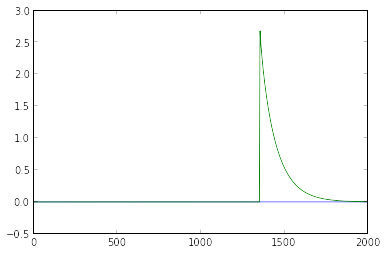

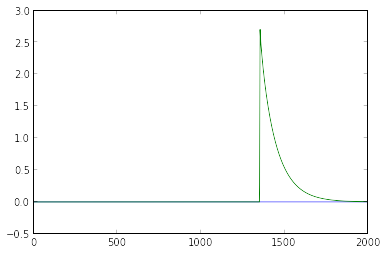

In [3]:


for (eid, wn) in ((1, wn1), (2, wn2)):
    tmnodes = sg.get_template_nodes(eid, wn.sta, "P", wn.band, wn.chan)
    k, n = tmnodes["coda_height"]
    n.set_value(1.0)
    k, n = tmnodes["coda_decay"]
    n.set_value(-3.0)
    k, n = tmnodes["peak_decay"]
    n.set_value(-3.0)
    figure()
    plot(wn.get_value().data)
    wn._parent_values()
    mean_obs = wn.tssm.mean_obs(wn.npts)
    plot(mean_obs)

In [4]:
"""
_, _, env, sidx, npts, lbl = wn1.tssm_components[1]
sidx -= 1200
N=451

from sigvisa.models.noise.armodel.model import ARModel, ErrorModel
wn1.nm.params = [0.0,]
wn1.nm.p = 1
wn1.nm.c= 0
wn1.nm.em.std = 0.1

cm = wn1.nm.cov_matrix(3)



import scipy.stats
np.random.seed(0)

from sigvisa.ssms_c import ARSSM, TransientCombinedSSM
arssm = ARSSM(np.array(wn1.nm.params, dtype=np.float), wn1.nm.em.std**2, 0.0, wn1.nm.c)
#print arssm.run_filter(z1)

cssm = wn1.arrival_ssms[(1, "P")]
pm, pv = cssm.get_coef_prior()
pv[0] = 1.0
cssm.set_coef_prior(pm, pv)

#tssm1 = TransientCombinedSSM([(cssm, sidx, npts, env)], 0.01)
#z1 = tssm1.prior_sample(N)
#plot(z1)

tssm2 = TransientCombinedSSM([(wn1.noise_arssm, 0, N, None), (cssm, sidx, npts, env), (wn1.iid_arssm, sidx, npts, wn1.tssm_components[2][2]), (None, sidx, npts, wn1.tssm_components[3][2])], 0.0)
figure()
z2 = wn1.get_value().data[:N]
plot(z2)
#print tssm1.run_filter(z1)
#print tssm2.run_filter(z1)
#print tssm1.run_filter(z2)
#print tssm2.run_filter(z2)



#C = np.eye(2000)*0.01
#C[sidx:sidx+300, sidx:sidx+300] += np.outer(env[:300], env[:300])
#C = C[:N, :N]
#rv = scipy.stats.multivariate_normal(mean=np.zeros(N,), cov=C)
#print rv.logpdf(z1)
#print rv.logpdf(z2)
tssm = tssm2 #wn1.tssm

n_coefs = 1
cssm.set_coef_prior(np.zeros((n_coefs)), np.ones((n_coefs))*1e20)
message_ll1 = tssm.run_filter(z2) 
message_ll2 = message_ll1 - scipy.stats.norm.logpdf(0, scale=np.sqrt(1e20))
print message_ll1, message_ll2

message_means, message_vars = tssm.all_filtered_cssm_coef_marginals(z2)[1]
#print message_means, message_vars
cssm.set_coef_prior(message_means, np.zeros(message_means.shape))
ll_at_mean = tssm.run_filter(z2)
normalized_at_mean = np.sum([scipy.stats.norm(scale=np.sqrt(v)).logpdf(0) for v in message_vars])
print ll_at_mean, normalized_at_mean, ll_at_mean - normalized_at_mean
"""

'\n_, _, env, sidx, npts, lbl = wn1.tssm_components[1]\nsidx -= 1200\nN=451\n\nfrom sigvisa.models.noise.armodel.model import ARModel, ErrorModel\nwn1.nm.params = [0.0,]\nwn1.nm.p = 1\nwn1.nm.c= 0\nwn1.nm.em.std = 0.1\n\ncm = wn1.nm.cov_matrix(3)\n\n\n\nimport scipy.stats\nnp.random.seed(0)\n\nfrom sigvisa.ssms_c import ARSSM, TransientCombinedSSM\narssm = ARSSM(np.array(wn1.nm.params, dtype=np.float), wn1.nm.em.std**2, 0.0, wn1.nm.c)\n#print arssm.run_filter(z1)\n\ncssm = wn1.arrival_ssms[(1, "P")]\npm, pv = cssm.get_coef_prior()\npv[0] = 1.0\ncssm.set_coef_prior(pm, pv)\n\n#tssm1 = TransientCombinedSSM([(cssm, sidx, npts, env)], 0.01)\n#z1 = tssm1.prior_sample(N)\n#plot(z1)\n\ntssm2 = TransientCombinedSSM([(wn1.noise_arssm, 0, N, None), (cssm, sidx, npts, env), (wn1.iid_arssm, sidx, npts, wn1.tssm_components[2][2]), (None, sidx, npts, wn1.tssm_components[3][2])], 0.0)\nfigure()\nz2 = wn1.get_value().data[:N]\nplot(z2)\n#print tssm1.run_filter(z1)\n#print tssm2.run_filter(z1)\n#print 

In [4]:
sg.current_log_p(verbose=False)

ASAR 3446.86118705 -241.302415833 -241.302415833 3688.16360288
ASAR 2468.67955344 -211.638319982 -211.638319982 2680.31787342


5882.5603689783402

In [5]:

wn1.pass_jointgp_messages()
wn2.pass_jointgp_messages()

In [6]:
print wn1.arrival_ssms

{(1, 'P'): <sigvisa.ssms_c.CompactSupportSSM object at 0x3d7cec0>}


In [7]:
print wn1.upwards_message_normalizer()


3688.16360288


In [12]:
#print sg.current_log_p(verbose=True)

#print sg.current_log_p_breakdown()

In [8]:
jgp = wn2.wavelet_param_models['P'][0]

global_lp1 = wn1.upwards_message_normalizer() + wn2.upwards_message_normalizer() + jgp.log_likelihood()
conditional_lp1 = wn2.conditional_log_p()
#unconditional_lp1 = wn2.log_p(force_joint=True)

tmnodes = sg.get_template_nodes(2, wn.sta, "P", wn.band, wn.chan)
k, n = tmnodes["coda_height"]
n.set_value(1.1)
wn2._parent_values()
wn2.pass_jointgp_messages()

#unconditional_lp2 = wn2.log_p(force_joint=True)
conditional_lp2 = wn2.conditional_log_p()
global_lp2 = wn1.upwards_message_normalizer() + wn2.upwards_message_normalizer() + jgp.log_likelihood()

k, n = tmnodes["coda_height"]
n.set_value(1.0)
wn2._parent_values()
wn2.pass_jointgp_messages()

print "global", global_lp2-global_lp1
print "conditional", conditional_lp2-conditional_lp1


ASAR 2442.49884147 -213.220980245 -213.220980245 2655.71982172
global -24.6011922774
conditional -22.2138368577


In [29]:
print global_lp1, global_lp2
print conditional_lp1, conditional_lp2


6337.13911928 6312.54111882
2511.1726339 2488.87939584


In [20]:
_, _, env1, sidx1, npts1, lbl = wn1.tssm_components[1]
_, _, env2, sidx2, npts2, lbl = wn2.tssm_components[1]

d1 = wn1.get_value().data
d2 = wn2.get_value().data

# distribution on d1:
# 

In [10]:
print sg.current_log_p(verbose=True)

print sg.current_log_p_breakdown()

node 2;mb has logp -3.7
node 2;loc has logp -8.9
node 2;P;ASAR;SHZ;freq_0.8_4.5;peak_offset has logp -0.9
node 2;P;ASAR;SHZ;freq_0.8_4.5;coda_decay has logp -5.4
node 2;P;ASAR;:;:;tt_residual has logp -0.9
node 2;time has logp 0.0
node 2;P;ASAR;SHZ;freq_0.8_4.5;peak_decay has logp -5.4
node 2;P;ASAR;:;:;amp_transfer has logp -2.8
node 2;source has logp -0.0
values {'coda_height': 1.0, 'arrival_time': 1240244584.2736063, 'coda_decay': -3.0, 'peak_decay': -3.0, 'peak_offset': -0.5}
pm [ 0.]
pv [  1.00000000e+30]
env 244.239050078
z1 2631.50234489 un -35.4577149281
node wave_ASAR_SHZ_freq_0.8_4.5_1240244314.3 has logp 2667.0
node 1;loc has logp -8.9
node 1;mb has logp -3.7
node 1;P;ASAR;:;:;amp_transfer has logp -2.8
node 1;source has logp -0.0
node 1;P;ASAR;SHZ;freq_0.8_4.5;coda_decay has logp -5.4
node 1;P;ASAR;:;:;tt_residual has logp -0.9
node 1;time has logp 0.0
node 1;P;ASAR;SHZ;freq_0.8_4.5;peak_decay has logp -5.4
node 1;P;ASAR;SHZ;freq_0.8_4.5;peak_offset has logp -0.9
values {'c

In [3]:
from sigvisa.treegp.gp import GP

X1 = np.array((4.0, 4.0, 0.0, 0.0, 5.0)).reshape(1, -1)
X2 = np.array((4.1, 4.1, 0.0, 0.0, 5.0)).reshape(1, -1)
X = np.vstack([X1, X2])

y1 = np.array((3.2,))
y2 = np.array((3.1,))
y = np.concatenate((y1, y2))
print y

yv1 = np.array((0.4,))
yv2 = np.array((0.2,))
yv = np.concatenate((yv1, yv2))
print yv

gp = GP(X=X, y=y, y_obs_variances=yv, noise_var=0.1, cov_main=gpcov, compute_ll=True, sparse_invert=True)
print gp.log_likelihood()

print gp.predict_tree.sparse_training_kernel_matrix(gp.X, 1.0, False)

gp1 = GP(X=X1, y=y1, y_obs_variances=yv1 , noise_var=0.1, cov_main=gpcov, compute_ll=True, sparse_invert=True)
print gp1.log_likelihood()
print gp1.predict(X2)
print gp1.variance(X2)

import scipy.stats
lp2 = scipy.stats.norm.logpdf(y2[0], loc=gp1.predict(X2), scale=np.sqrt(gp1.variance(X2) + 0.1 + yv2))
print gp1.log_likelihood() + lp2

[ 3.2  3.1]
[ 0.4  0.2]
-10.0155198303
[[ 0.          0.          0.7       ]
 [ 0.          1.          0.13263612]
 [ 1.          0.          0.13263612]
 [ 1.          1.          0.7       ]]
-5.27676594688
0.353696319335
[ 0.68533973]
[-10.01551983]


In [1]:
print conditional_lp2-conditional_lp1

NameError: name 'conditional_lp2' is not defined